# Compare the effect of different scalers on data with outliers

The TargetEncoder uses the value of the target to encode each categorical feature. In this example, we will compare three different approaches for handling categorical features: TargetEncoder, OrdinalEncoder, OneHotEncoder and dropping the category.



In [61]:
import matplotlib as mpl
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

In [29]:
dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
feature_names = dataset.feature_names

feature_mapping = {
    "MedInc": "Median income in block",
    "HouseAge": "Median house age in block",
    "AveRooms": "Average number of rooms",
    "AveBedrms": "Average number of bedrooms",
    "Population": "Block population",
    "AveOccup": "Average house occupancy",
    "Latitude": "House block latitude",
    "Longitude": "House block longitude",
}

In [32]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [33]:
# Take only 2 features to make visualization easier
# Feature MedInc has a long tail distribution.
# Feature AveOccup has a few but very large outliers.
features = ["MedInc", "AveOccup"]
features_idx = [feature_names.index(feature) for feature in features]
X = X_full[:, features_idx]

In [62]:
pd.DataFrame(X).describe()

,0,1
count,20640.000000,20640.000000
mean,3.870671,3.070655
std,1.899822,10.386050
min,0.499900,0.692308
25%,2.563400,2.429741
50%,3.534800,2.818116
75%,4.743250,3.282261
max,15.000100,1243.333333


In [41]:
distributions = [
    ("Unscaled data", X),
    ("Data after standard scaling", StandardScaler().fit_transform(X)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X)),
    (
        "Data after robust scaling",
        RobustScaler(quantile_range=(25, 75)).fit_transform(X),
    ),
    (
        "Data after power transformation (Yeo-Johnson)",
        PowerTransformer(method="yeo-johnson").fit_transform(X),
    ),
    (
        "Data after power transformation (Box-Cox)",
        PowerTransformer(method="box-cox").fit_transform(X),
    ),
    (
        "Data after quantile transformation (uniform pdf)",
        QuantileTransformer(
            output_distribution="uniform", random_state=42
        ).fit_transform(X),
    ),
    (
        "Data after quantile transformation (gaussian pdf)",
        QuantileTransformer(
            output_distribution="normal", random_state=42
        ).fit_transform(X),
    ),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X)),
]

In [43]:
y_full

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [44]:
# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, "plasma_r", cm.hot_r)

In [45]:
y

array([0.90226638, 0.70824656, 0.69505074, ..., 0.15938285, 0.14371281,
       0.15340349])

In [46]:
def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )

In [47]:
def plot_distribution(axes, X, y, hist_nbins=50, title="", x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(
        X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey"
    )
    hist_X1.axis("off")

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(
        X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey"
    )
    hist_X0.axis("off")

# Create the plot to analyze different scalers

Two plots will be shown for each scaler/normalizer/transformer. The left figure will show a scatter plot of the full data set while the right figure will exclude the extreme values considering only 99 % of the data set, excluding marginal outliers. In addition, the marginal distributions for each feature will be shown on the sides of the scatter plot.

In [48]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(
        axarr[0],
        X,
        y,
        hist_nbins=200,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Full data",
    )

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )
    plot_distribution(
        axarr[1],
        X[non_outliers_mask],
        y[non_outliers_mask],
        hist_nbins=50,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping for values of y",
    )

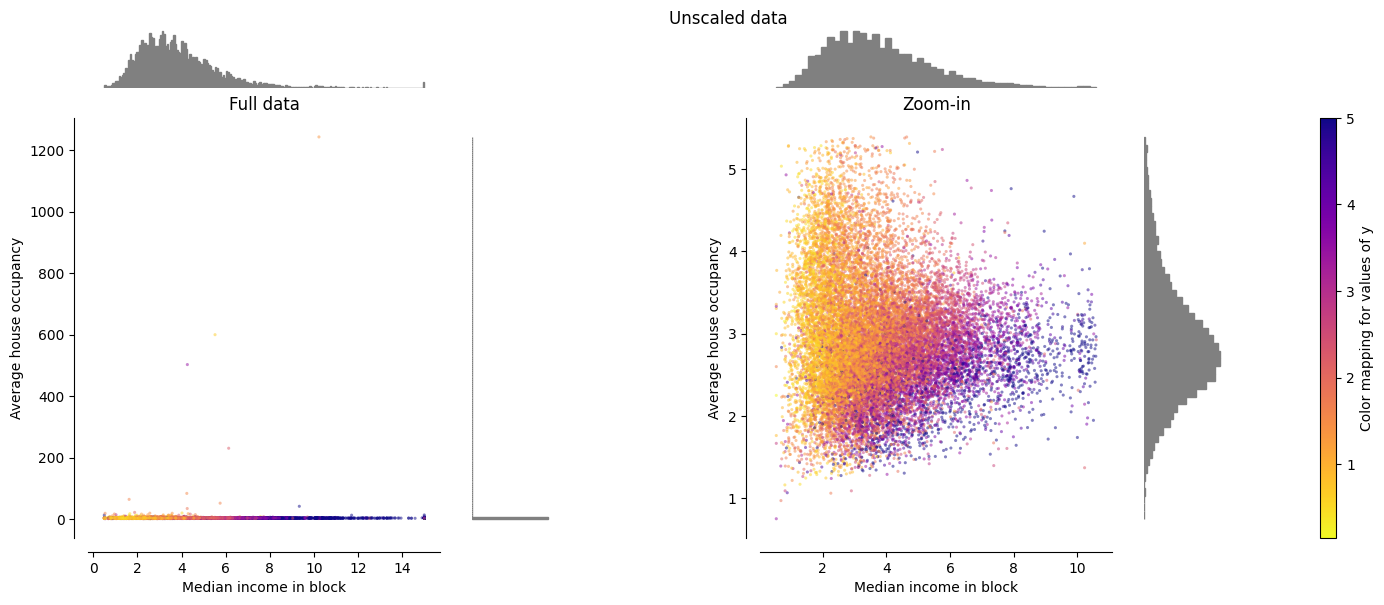

In [49]:
make_plot(0)

Each transformation is visualized using two plots: a full dataset view and a zoomed-in view excluding marginal outliers. The data clusters around specific ranges, with most median incomes between 0 and 10 and average house occupancies between 0 and 6. However, some outliers, particularly in average occupancy, can significantly impact the data distribution. The choice of pre-processing technique should consider the specific application and the desired outcome.

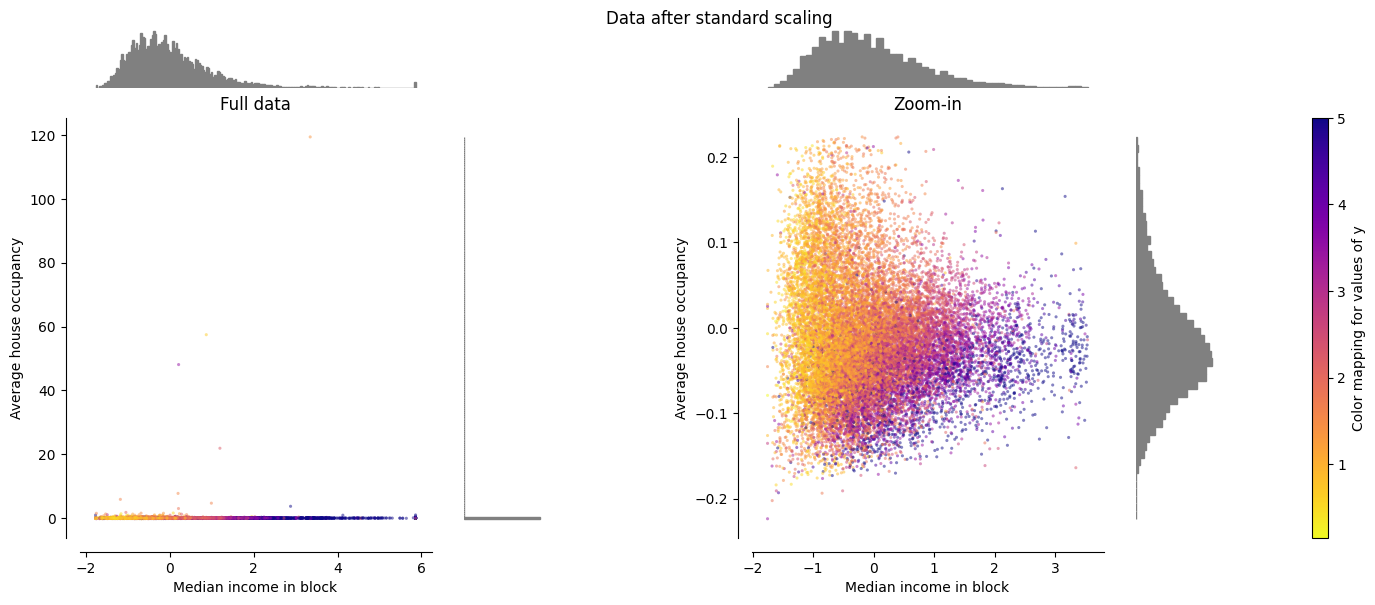

In [50]:
make_plot(1)

StandardScaler removes the mean and scales the data to unit variance. The scaling shrinks the range of the feature values as shown in the left figure below. However, the outliers have an influence when computing the empirical mean and standard deviation. Note in particular that because the outliers on each feature have different magnitudes, the spread of the transformed data on each feature is very different: most of the data lie in the [-2, 4] range for the transformed median income feature while the same data is squeezed in the smaller [-0.2, 0.2] range for the transformed average house occupancy.

StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

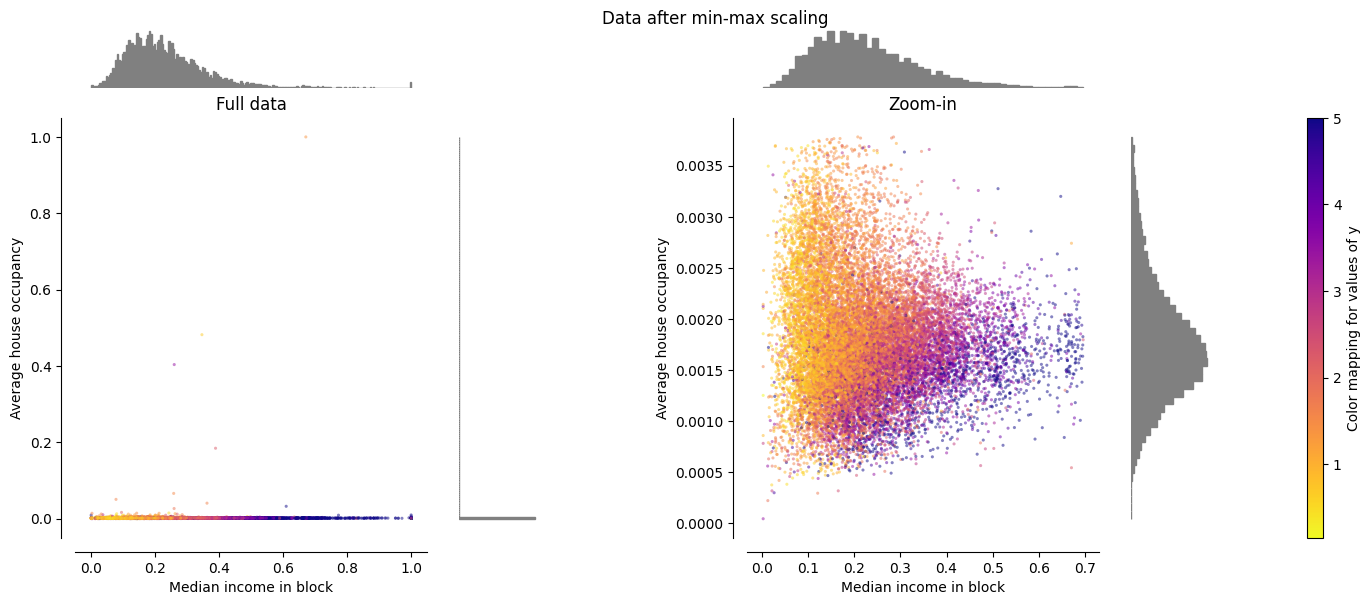

In [51]:
make_plot(2)

MinMaxScaler rescales the data set such that all feature values are in the range [0, 1] as shown in the right panel below. However, this scaling compresses all inliers into the narrow range [0, 0.005] for the transformed average house occupancy.

MinMaxScaler are very sensitive to the presence of outliers.

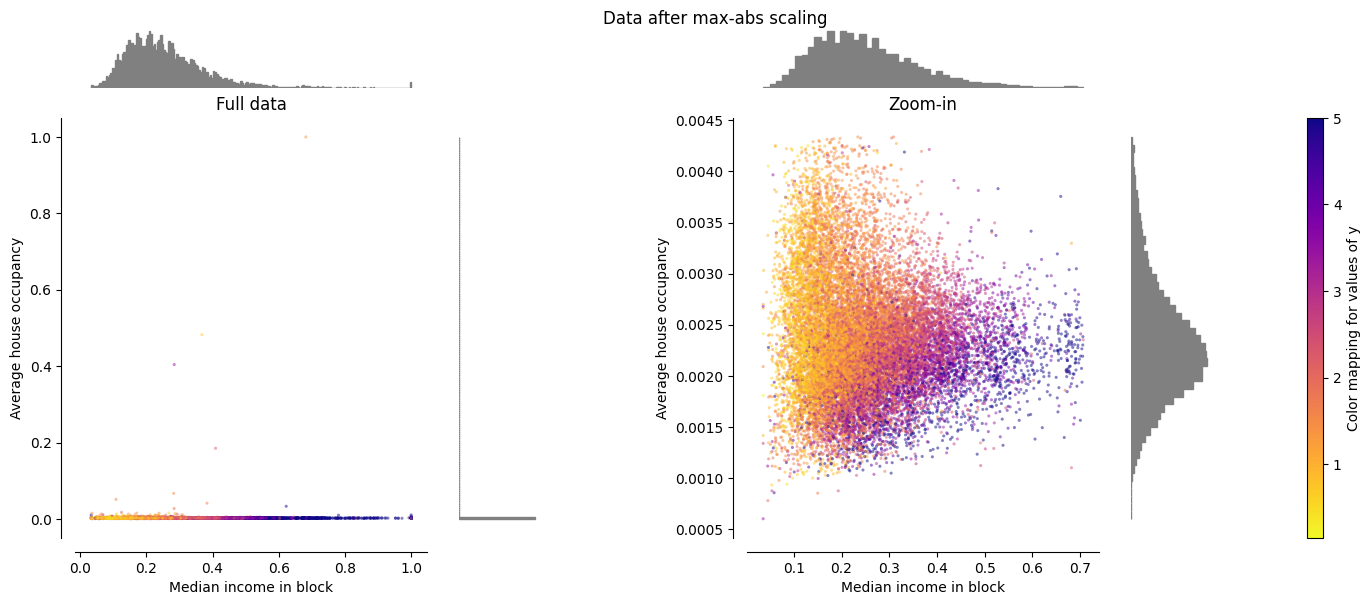

In [52]:
make_plot(3)

MaxAbsScaler is similar to MinMaxScaler except that the values are mapped across several ranges depending on whether negative OR positive values are present. If only positive values are present, the range is [0, 1]. If only negative values are present, the range is [-1, 0]. If both negative and positive values are present, the range is [-1, 1].

MaxAbsScaler therefore also suffers from the presence of large outliers.

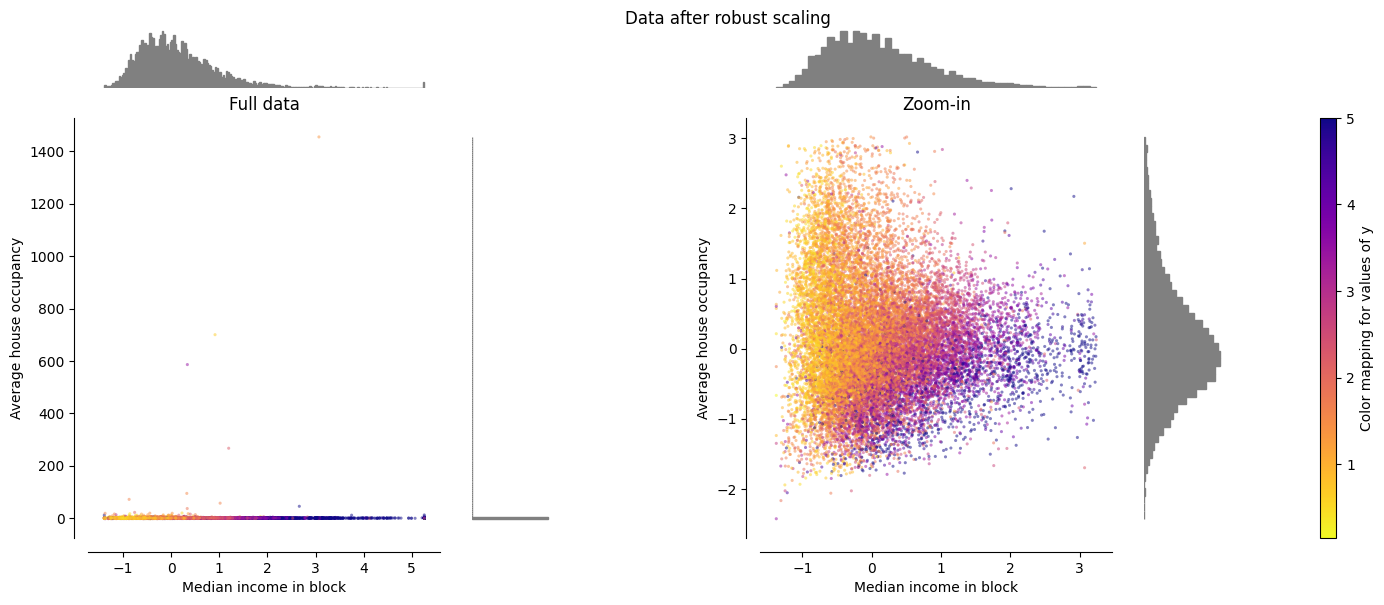

In [53]:
make_plot(4)

the centering and scaling statistics of RobustScaler are based on percentiles and are therefore not influenced by a small number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar: for both features most of the transformed values lie in a [-2, 3] range as seen in the zoomed-in figure. Note that the outliers themselves are still present in the transformed data. If a separate outlier clipping is desirable, a non-linear transformation is required (see below).

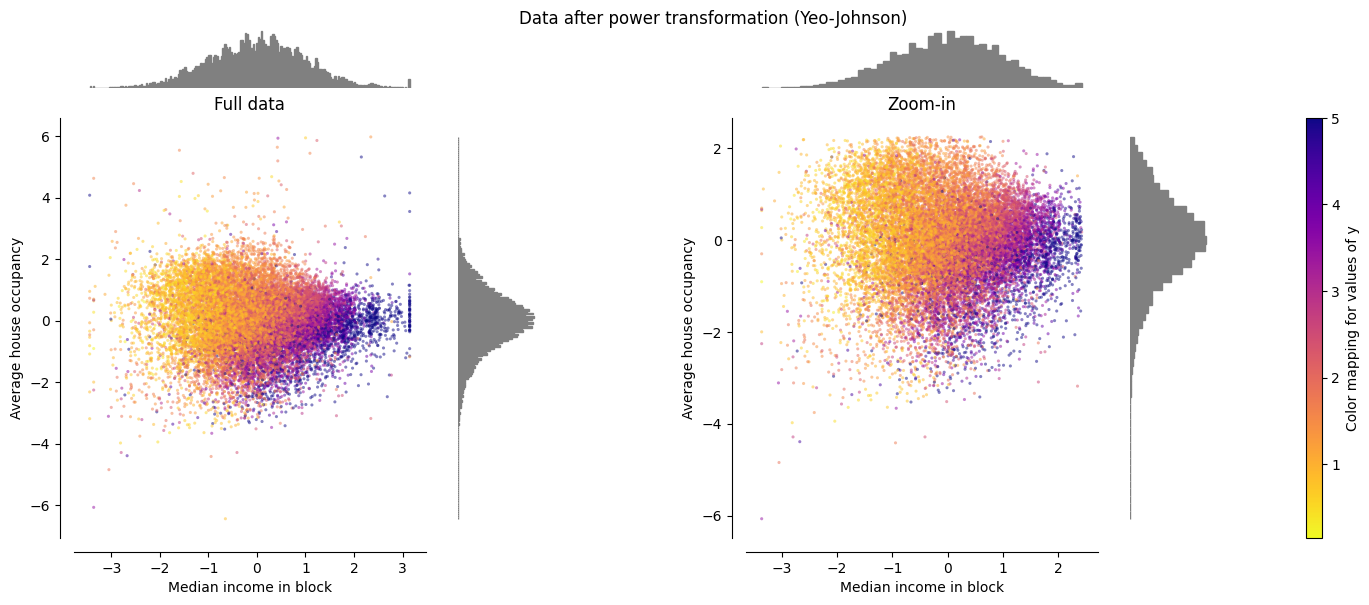

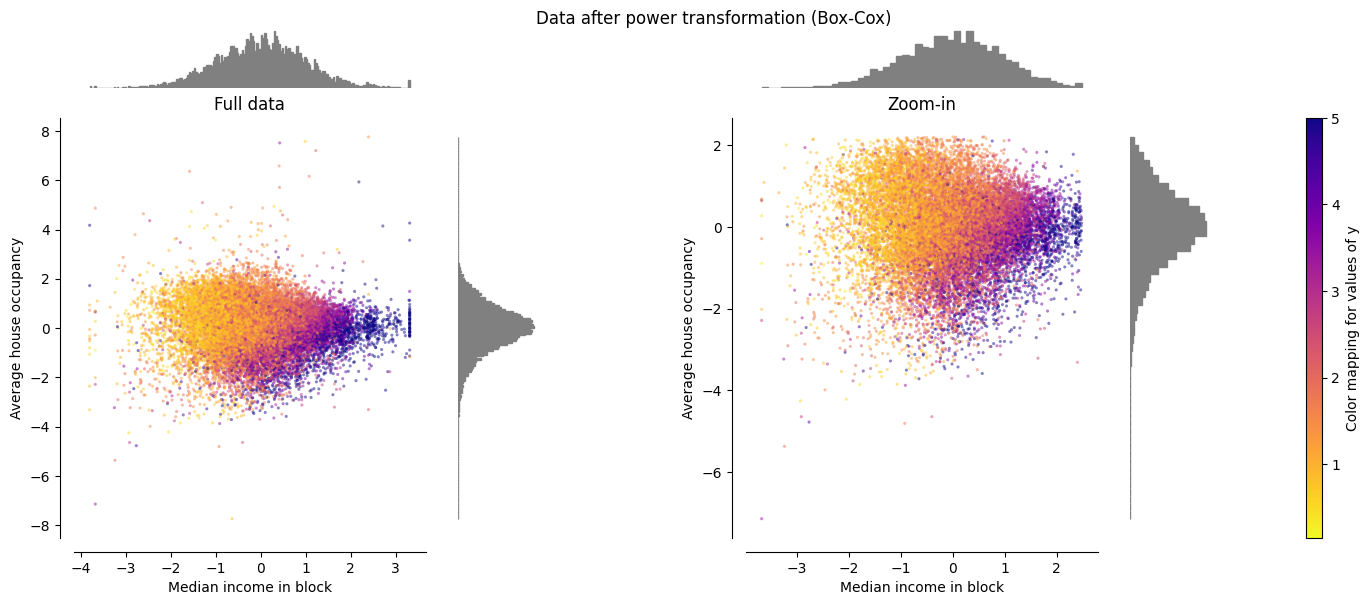

In [54]:
make_plot(5)
make_plot(6)

PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness. Currently the Yeo-Johnson and Box-Cox transforms are supported and the optimal scaling factor is determined via maximum likelihood estimation in both methods. By default, PowerTransformer applies zero-mean, unit variance normalization. Note that Box-Cox can only be applied to strictly positive data. Income and average house occupancy happen to be strictly positive, but if negative values are present the Yeo-Johnson transformed is preferred.

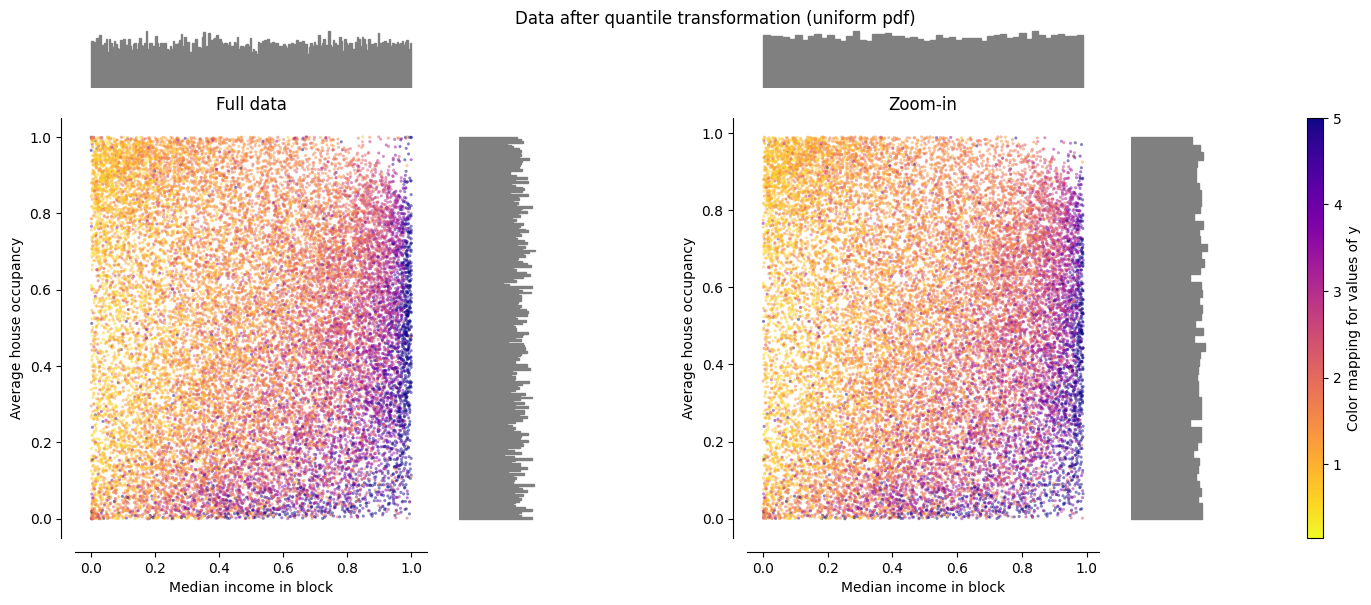

In [55]:
make_plot(7)

QuantileTransformer applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data, including outliers, will be mapped to a uniform distribution with the range [0, 1], making outliers indistinguishable from inliers.

RobustScaler and QuantileTransformer are robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1). This can result in saturation artifacts for extreme values.

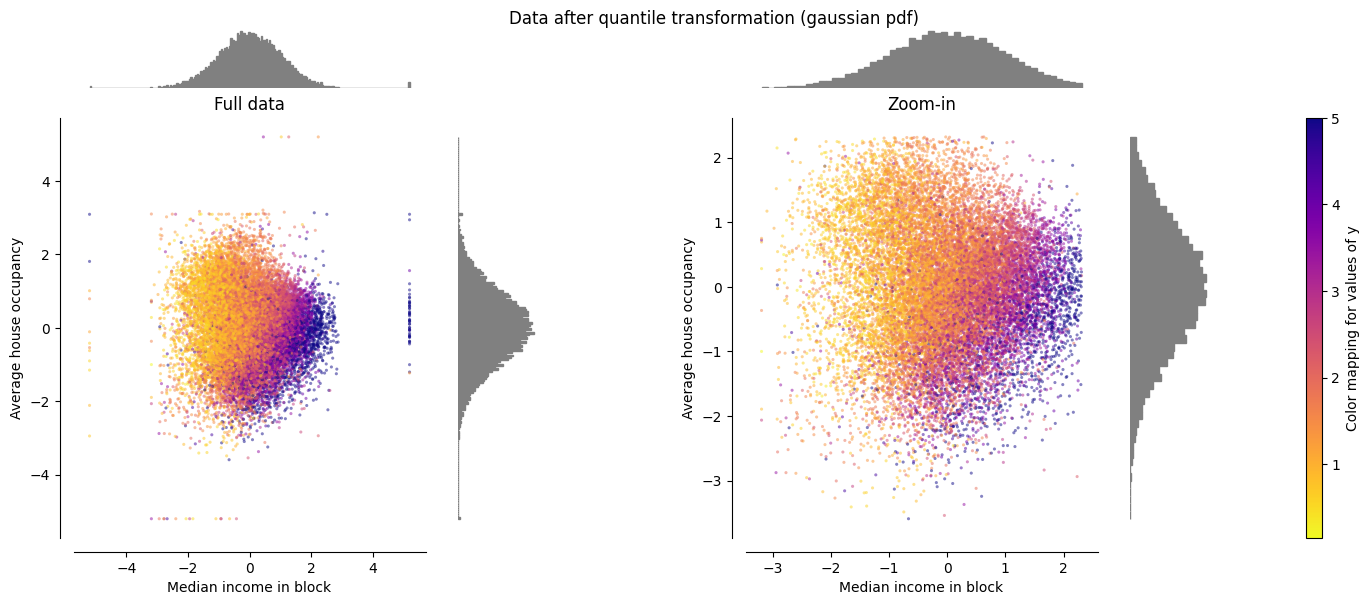

In [56]:
make_plot(8)

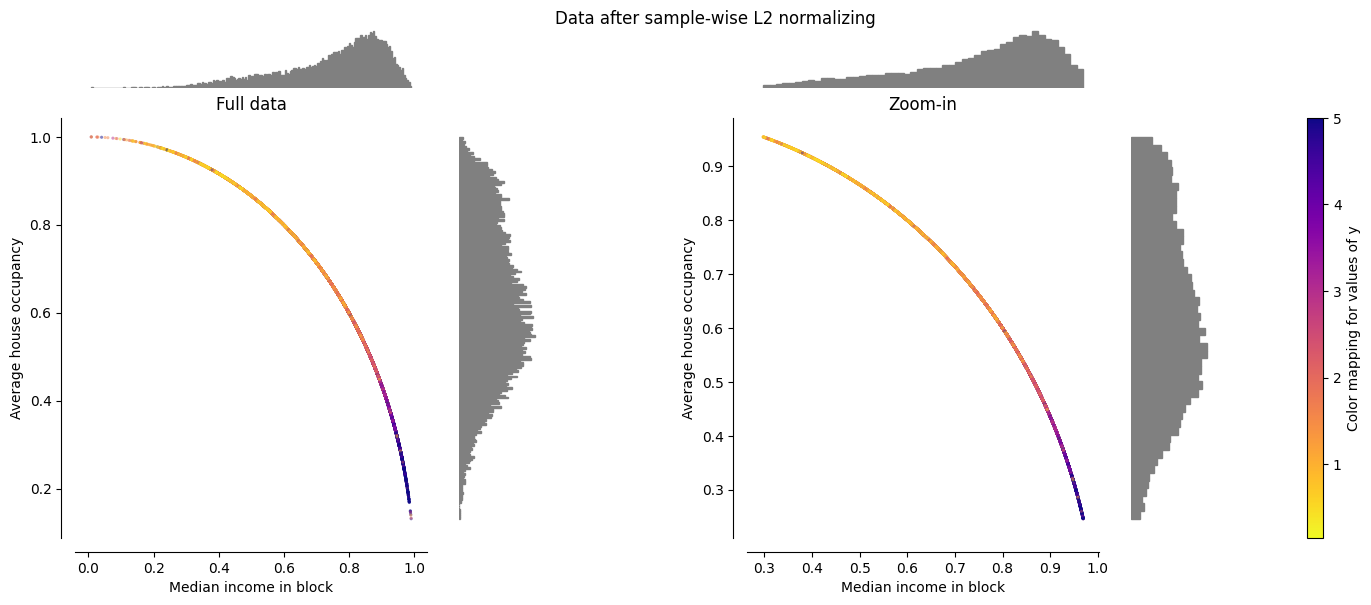

In [57]:
make_plot(9)

plt.show()

The Normalizer rescales the vector for each sample to have unit norm, independently of the distribution of the samples. It can be seen on both figures below where all samples are mapped onto the unit circle. In our example the two selected features have only positive values; therefore the transformed data only lie in the positive quadrant. This would not be the case if some original features had a mix of positive and negative values.